In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
#!unzip yawn_eye.zip

In [5]:
cd yawn_eye

/content/drive/MyDrive/yawn_eye


In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="training",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 2221 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="validation",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 246 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="test",
    labels="inferred",
    batch_size=32,
    image_size=(256,256),
    validation_split=None,
)

Found 433 files belonging to 4 classes.


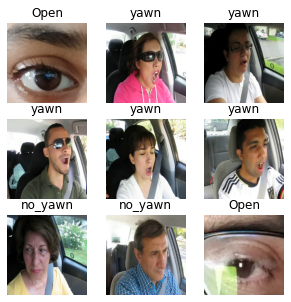

In [ ]:
class_names=train_ds.class_names
plt.figure(figsize=(5, 5))
for images ,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [9]:
aututune = tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=aututune)
val_ds=val_ds.cache().prefetch(buffer_size=aututune)
test_ds=test_ds.cache().prefetch(buffer_size=aututune)

In [10]:
data_augmentation= tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, -0.1)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

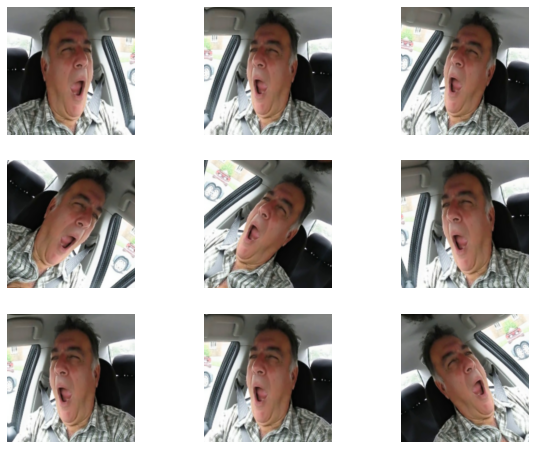

In [11]:
image , label= next(iter(train_ds))
plt.figure(figsize=(10,8))
first_image=image[13]
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  augmented_image=data_augmentation(first_image)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis('off')

In [12]:
model_vgg=tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
model_vgg.trainable=False

In [15]:
inputs= tf.keras.Input(shape=(256,256,3))
x=data_augmentation(inputs)
x=model_vgg(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(32,activation='elu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(64,activation='elu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
outputs=tf.keras.layers.Dense(4,activation="softmax")(x)
new_model=tf.keras.Model(inputs,outputs)

In [16]:
new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [17]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                2112  

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
checkpoint =  tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/tmp/checkpoint',
    monitor='val_accuracy', mode='max',save_best_only=True
)
history=new_model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[callback,checkpoint])

Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.7479

70/70 [==============================] - 414s 6s/step - loss: 0.5193 - accuracy: 0.7479 - val_loss: 0.2452 - val_accuracy: 0.9024
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.8955

70/70 [==============================] - 18s 259ms/step - loss: 0.2499 - accuracy: 0.8955 - val_loss: 0.1624 - val_accuracy: 0.9390
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9347

70/70 [==============================] - 18s 262ms/step - loss: 0.1639 - accuracy: 0.9347 - val_loss: 0.1093 - val_accuracy: 0.9553
Epoch 4/50
70/70 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9653

70/70 [==============================] - 19s 266ms/step - loss: 0.1088 - accuracy: 0.9653 - val_loss: 0.1059 - val_accuracy: 0.9675
Epoch 5/50
70/70 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9793

70/70 [==============================] - 18s 262ms/step - loss: 0.0738 - accuracy: 0.9793 - val_loss: 0.0619 - val_accuracy: 0.9919
Epoch 6/50
70/70 [==============================] - 15s 218ms/step - loss: 0.0544 - accuracy: 0.9842 - val_loss: 0.0769 - val_accuracy: 0.9675
Epoch 7/50
70/70 [==============================] - 16s 223ms/step - loss: 0.0413 - accuracy: 0.9874 - val_loss: 0.1289 - val_accuracy: 0.9512
Epoch 8/50
70/70 [==============================] - 16s 222ms/step - loss: 0.0321 - accuracy: 0.9910 - val_loss: 0.2394 - val_accuracy: 0.9146
Epoch 9/50
70/70 [==============================] - 16s 222ms/step - loss: 0.0266 - accuracy: 0.9923 - val_loss: 0.0509 - val_accuracy: 0.9919
Epoch 10/50
70/70 [==============================] - 15s 220ms/step - loss: 0.0220 - accuracy: 0.9959 - val_loss: 0.0544 - val_accuracy: 0.9837
Epoch 11/50
70/70 [==============================] - 15s 220ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.5441 - val_accuracy: 0.8821
Epoch 12

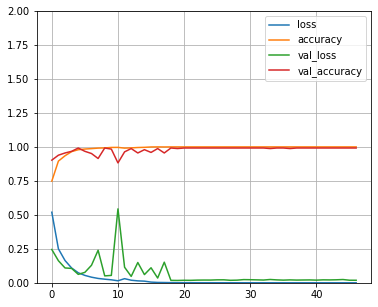

In [19]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [20]:
loss_t, acc_t= new_model.evaluate(test_ds)
print(acc_t)

14/14 [==============================] - 104s 3s/step - loss: 0.1393 - accuracy: 0.9723
0.9722864031791687


In [21]:
y_pred=new_model.predict(test_ds)

14/14 [==============================] - 3s 192ms/step


In [22]:
y_pred

array([[3.3144327e-09, 3.6043142e-09, 9.9999917e-01, 8.6797195e-07],
       [9.9999988e-01, 1.0380853e-08, 7.9528917e-08, 1.0474051e-08],
       [5.4611031e-05, 8.0822820e-06, 2.2676468e-05, 9.9991465e-01],
       ...,
       [9.9999964e-01, 3.9664211e-08, 1.8927700e-07, 1.5568152e-07],
       [1.9846621e-07, 1.4620559e-09, 3.2853228e-10, 9.9999976e-01],
       [1.0156451e-07, 9.9999988e-01, 1.9409407e-09, 4.5982390e-10]],
      dtype=float32)

In [23]:
y_pred=np.argmax(y_pred, axis=1)
y_pred

array([2, 0, 3, 3, 0, 3, 1, 2, 1, 0, 0, 2, 0, 3, 3, 1, 3, 1, 2, 1, 1, 0,
       2, 1, 1, 3, 1, 3, 3, 0, 2, 2, 3, 1, 1, 0, 2, 0, 3, 1, 1, 2, 2, 0,
       0, 1, 1, 0, 1, 3, 2, 1, 1, 0, 2, 0, 2, 3, 3, 0, 3, 2, 0, 1, 2, 0,
       1, 0, 1, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1, 3, 1, 3, 2, 0, 3, 0, 2, 0,
       2, 2, 3, 0, 3, 2, 2, 2, 0, 0, 2, 3, 0, 3, 0, 3, 3, 2, 3, 2, 2, 1,
       3, 2, 1, 2, 0, 3, 3, 0, 0, 0, 3, 3, 2, 3, 0, 3, 1, 1, 1, 3, 3, 3,
       3, 2, 1, 1, 2, 1, 1, 3, 1, 2, 0, 0, 2, 3, 2, 0, 2, 0, 2, 2, 3, 3,
       0, 2, 1, 2, 1, 0, 2, 3, 0, 1, 0, 1, 3, 1, 3, 0, 3, 1, 2, 3, 3, 3,
       0, 3, 2, 2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 3, 1, 1, 2, 3, 0, 2, 3, 2,
       1, 1, 2, 0, 0, 1, 0, 3, 0, 0, 2, 1, 0, 3, 1, 3, 0, 3, 2, 3, 2, 2,
       2, 2, 0, 3, 1, 1, 2, 3, 2, 3, 1, 3, 0, 0, 1, 2, 1, 3, 0, 2, 1, 1,
       3, 2, 0, 0, 0, 3, 3, 1, 2, 1, 3, 2, 0, 0, 1, 0, 0, 3, 2, 2, 0, 2,
       0, 0, 3, 2, 2, 3, 2, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 1, 0, 2, 0,
       0, 2, 0, 1, 1, 2, 1, 0, 2, 3, 2, 3, 2, 2, 0,

In [24]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test

array([2, 0, 3, 3, 0, 3, 1, 2, 1, 0, 0, 3, 0, 3, 3, 1, 3, 1, 2, 1, 1, 0,
       2, 1, 1, 3, 1, 3, 3, 0, 2, 2, 3, 1, 1, 0, 2, 0, 3, 1, 1, 2, 2, 0,
       0, 1, 1, 0, 0, 3, 2, 1, 1, 0, 2, 0, 2, 3, 3, 0, 3, 2, 0, 1, 2, 0,
       1, 0, 1, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1, 3, 1, 3, 2, 0, 3, 0, 2, 0,
       2, 2, 3, 0, 3, 2, 2, 2, 0, 0, 2, 3, 0, 3, 0, 3, 3, 2, 3, 2, 2, 1,
       3, 2, 1, 2, 0, 3, 3, 0, 0, 0, 3, 3, 2, 3, 0, 3, 1, 1, 1, 3, 3, 3,
       3, 3, 1, 1, 2, 1, 1, 3, 1, 2, 0, 0, 2, 3, 2, 0, 2, 0, 2, 2, 3, 3,
       0, 2, 1, 2, 1, 0, 2, 3, 0, 1, 0, 1, 3, 1, 2, 0, 3, 1, 2, 3, 3, 3,
       1, 3, 3, 3, 0, 1, 0, 1, 2, 0, 2, 1, 2, 3, 1, 1, 2, 3, 0, 2, 3, 2,
       1, 1, 2, 0, 0, 1, 0, 3, 0, 0, 2, 1, 0, 3, 1, 3, 0, 3, 2, 3, 2, 2,
       2, 2, 0, 3, 1, 1, 2, 3, 2, 3, 1, 3, 0, 0, 1, 2, 1, 3, 0, 2, 1, 1,
       3, 2, 0, 0, 0, 3, 3, 1, 2, 1, 3, 2, 0, 0, 1, 0, 0, 3, 2, 2, 0, 2,
       0, 0, 3, 2, 3, 2, 2, 2, 0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 1, 0, 2, 0,
       0, 2, 0, 1, 1, 2, 1, 0, 2, 3, 2, 2, 2, 2, 0,

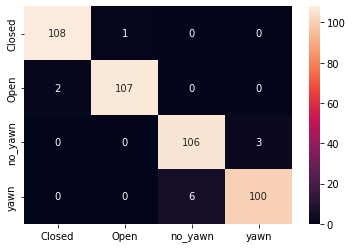

In [25]:
from sklearn.metrics import classification_report , confusion_matrix
report = classification_report(y_test, y_pred, target_names=['Closed', 'Open', 'no_yawn', 'yawn'],output_dict=True)
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, xticklabels=['Closed', 'Open', 'no_yawn', 'yawn'], yticklabels=['Closed', 'Open', 'no_yawn', 'yawn'], annot=True, fmt='d');

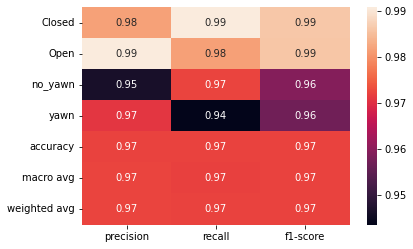

In [26]:
import seaborn as sns
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True);

In [27]:
new_model.save('/content/drive/MyDrive/Drowsiness_models/VGG_Model')